In [1]:
#From SAV to LOVE

# HW 

### Задача №1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.


In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [4]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
data_w = data.copy().resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [6]:
data_w = data_w.drop(['dayofmonth', 'month', 'dayofyear', 'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday','is_next_holiday'], axis = 1)
data_w.head()

,PJME_MW,year,quarter,weekofyear
Date,,,,
2002-01-06,32392.160839,2002.0,1.0,1.0
2002-01-13,31487.386905,2002.0,1.0,2.0
2002-01-20,31452.880952,2002.0,1.0,3.0
2002-01-27,30141.529762,2002.0,1.0,4.0
2002-02-03,29196.488095,2002.0,1.0,5.0


In [7]:
data_w.isnull().sum()

PJME_MW       0
year          0
quarter       0
weekofyear    0
dtype: int64

### Задача №2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .



Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... ,от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p=6))

Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

C:\Users\79811\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


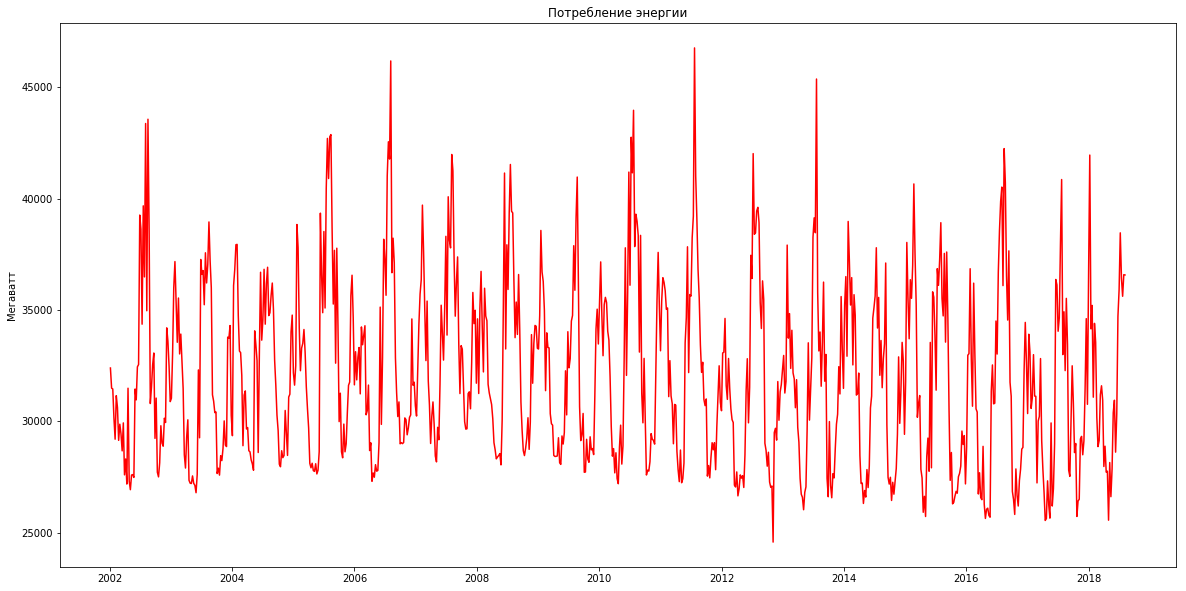

In [8]:
plt.figure(figsize =(20,10))
plt.plot( data_w.index.get_level_values('Date'), data_w['PJME_MW'], 'r' )
plt.title('Потребление энергии' )
plt.ylabel ( 'Мегаватт' )
plt.show()

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [10]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()


#### Генерация признаков

In [11]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
import seaborn as sns
scl=StandardScaler()
tsne_ =TSNE(n_components=2)
pca_ =PCA(n_components=2)


In [12]:
data_w.columns

Index(['PJME_MW', 'year', 'quarter', 'weekofyear'], dtype='object')

In [13]:
SELECTED_FEATURE_NAMES = ['PJME_MW', 'year', 'quarter', 'weekofyear']

In [14]:
X = data_w[SELECTED_FEATURE_NAMES]
X.head()

,PJME_MW,year,quarter,weekofyear
Date,,,,
2002-01-06,32392.160839,2002.0,1.0,1.0
2002-01-13,31487.386905,2002.0,1.0,2.0
2002-01-20,31452.880952,2002.0,1.0,3.0
2002-01-27,30141.529762,2002.0,1.0,4.0
2002-02-03,29196.488095,2002.0,1.0,5.0


In [15]:
Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)
X_p = pca_.fit_transform(Xscale)


In [16]:
X_t

array([[ 39.54513   ,   3.4590688 ],
       [ 38.66255   ,   3.6165805 ],
       [ 38.47116   ,   3.509287  ],
       ...,
       [-13.045318  ,   0.23688759],
       [-12.906639  ,  -0.91079646],
       [-13.121377  ,  -0.6476674 ]], dtype=float32)

In [17]:
data_w.head()

,PJME_MW,year,quarter,weekofyear
Date,,,,
2002-01-06,32392.160839,2002.0,1.0,1.0
2002-01-13,31487.386905,2002.0,1.0,2.0
2002-01-20,31452.880952,2002.0,1.0,3.0
2002-01-27,30141.529762,2002.0,1.0,4.0
2002-02-03,29196.488095,2002.0,1.0,5.0


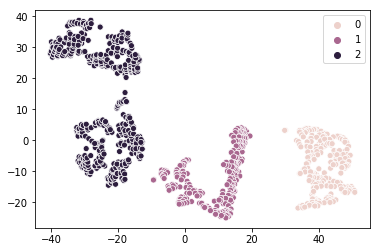

In [18]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=3, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

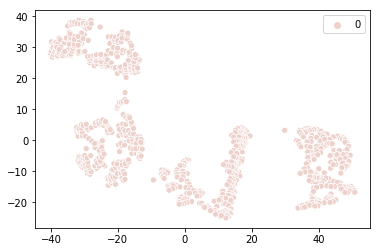

In [19]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast )
plt.show()

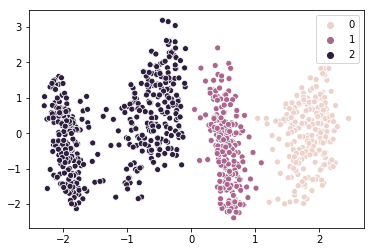

In [20]:
sns.scatterplot(X_p[:,0],X_p[:,1], hue=X_clast)
plt.show()

#### Результат кластер-анализа признаков

In [21]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  1
Число кластеров в календаре:  3


In [22]:
data_w['clast'] = X_clast
data_w.describe()

,PJME_MW,year,quarter,weekofyear,clast
count,866.000000,866.000000,866.000000,866.000000,866.000000
mean,32081.930877,2009.803365,2.481181,26.215935,1.234411
std,3982.384374,4.797106,1.098205,15.027629,0.831055
min,24577.173653,2002.000000,1.000000,1.000000,0.000000
25%,28791.333333,2006.000000,1.607143,13.000000,0.000000
50%,31424.488095,2010.000000,2.214286,26.000000,1.000000
75%,34817.644345,2014.000000,3.000000,39.000000,2.000000
max,46761.494048,2018.000000,4.000000,53.000000,2.000000


Text(0.5, 1.0, 'Потребление')

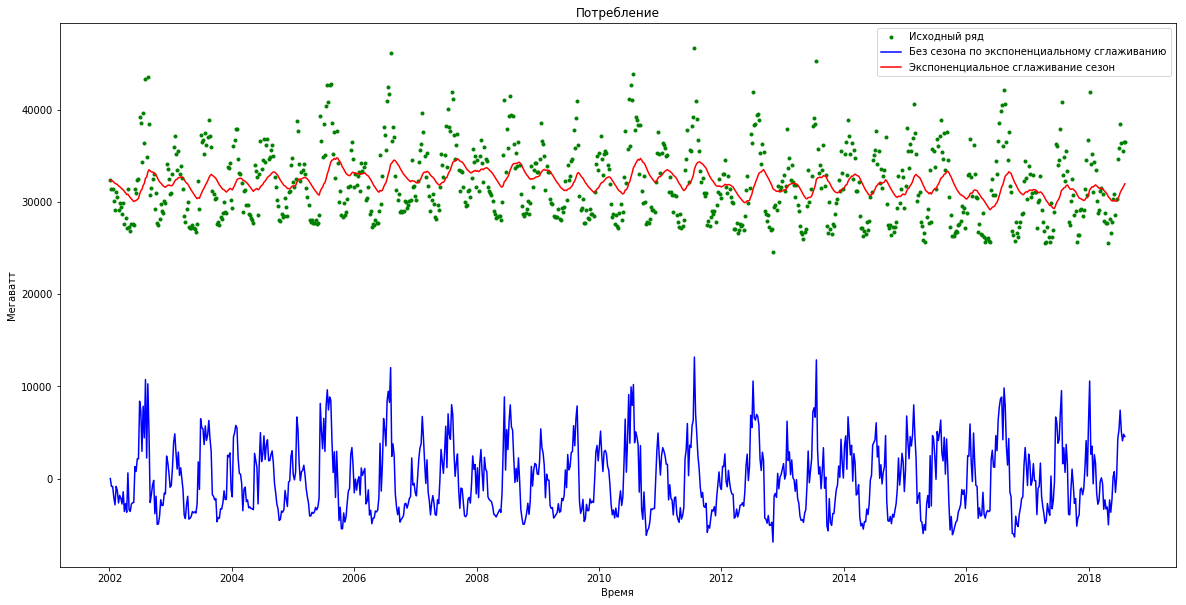

In [23]:
data_exp_1 = exponential_smoothing(data_w['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 10))
plt.plot(data_w.index, data_w['PJME_MW'].values, '.g',label='Исходный ряд')
plt.plot(data_w.index,data_w['PJME_MW'].values - data_exp_1 , color = 'b', label="Без сезона по экспоненциальному сглаживанию");
plt.plot(data_w.index,data_exp_1 , color = 'red', label="Экспоненциальное сглаживание сезон");
plt.xlabel('Время')
plt.ylabel('Мегаватт')
plt.legend()
plt.title('Потребление')

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [24]:
 # добавим историю на глубину 4 измерения от текущего (р=4)
p = 4
for i in range(1, p+1):
    data_w[f't{i}'] = 0.0
    data_w.iloc[i:,i+4]=data_w.iloc[:-i,0].values
data_w.fillna(0)
# добавим сглаживание 
data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)
# добавим первую разность
data_w['diff1'] = 0.0
data_w['diff1'].iloc[1:] = data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values
data_w.head()

C:\Users\79811\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,PJME_MW,year,quarter,weekofyear,clast,t1,t2,t3,t4,exp_0_05,diff1
Date,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.0,1.0,0,0.000000,0.000000,0.000000,0.000000,32392.160839,0.000000
2002-01-13,31487.386905,2002.0,1.0,2.0,0,32392.160839,0.000000,0.000000,0.000000,32346.922142,-904.773934
2002-01-20,31452.880952,2002.0,1.0,3.0,0,31487.386905,32392.160839,0.000000,0.000000,32302.220083,-34.505952
2002-01-27,30141.529762,2002.0,1.0,4.0,0,31452.880952,31487.386905,32392.160839,0.000000,32194.185567,-1311.351190
2002-02-03,29196.488095,2002.0,1.0,5.0,0,30141.529762,31452.880952,31487.386905,32392.160839,32044.300693,-945.041667


In [25]:
spl_data = '2018-03-01'

In [26]:
train, test = split_data( data_w, spl_data)

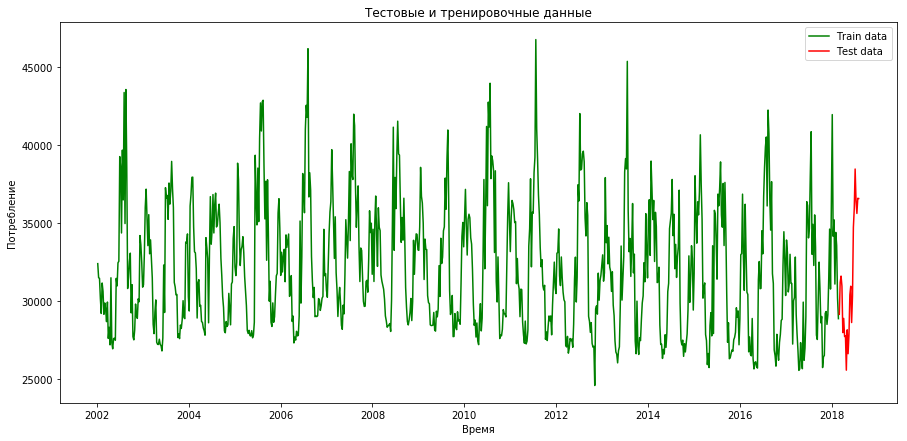

In [27]:
h=4
X_train = train.iloc[:-h,:]
y_train = train[data_w.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[data_w.columns[0]].values[h:]

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(train.index.get_level_values('Date'),train[data_w.columns[0]], label='Train data',color='g' )
plt.plot(test.index.get_level_values('Date'),test[data_w.columns[0]], label='Test data',color='r')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [28]:
X_test.head()

,PJME_MW,year,quarter,weekofyear,clast,t1,t2,t3,t4,exp_0_05,diff1
Date,,,,,,,,,,,
2018-03-04,29140.244048,2018.0,1.000000,9.0,0,28863.517857,30177.750000,33549.750000,34396.178571,31523.903020,276.726190
2018-03-11,31187.149701,2018.0,1.000000,10.0,0,29140.244048,28863.517857,30177.750000,33549.750000,31507.065354,2046.905653
2018-03-18,31593.827381,2018.0,1.000000,11.0,0,31187.149701,29140.244048,28863.517857,30177.750000,31511.403455,406.677680
2018-03-25,30951.833333,2018.0,1.000000,12.0,0,31593.827381,31187.149701,29140.244048,28863.517857,31483.424949,-641.994048
2018-04-01,27970.839286,2018.0,1.142857,13.0,0,30951.833333,31593.827381,31187.149701,29140.244048,31307.795666,-2980.994048


In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

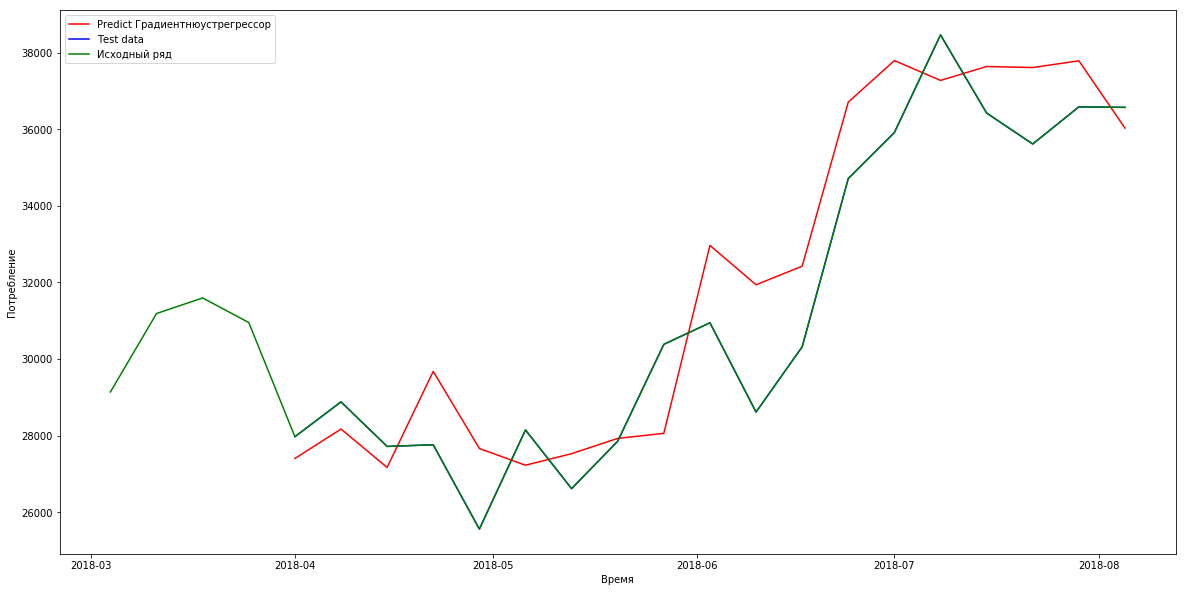

средняя ошибка в % отношении:   4.687549197816711 %


In [30]:
model_gb4 = GradientBoostingRegressor(max_depth=7, random_state=0, n_estimators=100)
model_gb4.fit( X_train, y_train ) 
y_pred4 = model_gb4.predict(X_test)

plt.figure( figsize=( 20, 10 ))

plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(test.index[h:],y_pred4, label='Predict Градиентнюустрегрессор',color='r' )
plt.plot(test.index[h:],y_test, label='Test data',color='b')
plt.plot(data_w.loc[spl_data:].index, data_w.loc[spl_data:]['PJME_MW'], label='Исходный ряд',color='g')
plt.legend()
plt.show()
er_g = mean_absolute_percentage_error(y_true=y_test, y_pred = y_pred4)

print('средняя ошибка в % отношении:  ', er_g, '%')


In [31]:
for i in range(5):
    er_g = mean_absolute_percentage_error(y_true=y_test[i*h:i*h+h], y_pred = y_pred4[i*h:i*h+h])
    print(f'средняя ошибка на интервале {i*h}:{i*h+h} \t {round(er_g,2)} %')

средняя ошибка на интервале 0:4 	 3.34 %
средняя ошибка на интервале 4:8 	 3.8 %
средняя ошибка на интервале 8:12 	 8.18 %
средняя ошибка на интервале 12:16 	 4.35 %
средняя ошибка на интервале 16:20 	 3.46 %


In [32]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_pred4) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_pred4) 
er_r2 = r2_score(y_true=y_test, y_pred=y_pred4)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   2735483.2213561554 
ошибка mae  :   1449.3949270072585 
оценка R2 :   0.8338236421115256


In [33]:
y_pred4

array([27403.54577016, 28170.77108918, 27169.56083784, 29676.11063055,
       27664.26708548, 27227.67775752, 27528.59037625, 27927.63060591,
       28059.04575064, 32964.92866858, 31937.62303644, 32423.01139277,
       36705.88249975, 37789.93406168, 37272.11075335, 37635.06864569,
       37608.00760352, 37784.32760218, 36027.60171309])

### Задача №3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.



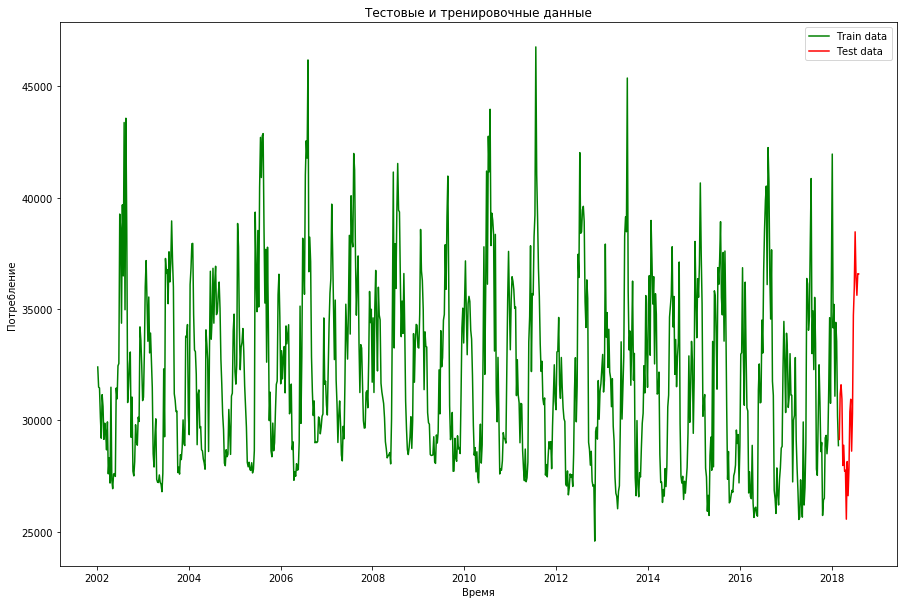

In [34]:
h=1
X_train = train.iloc[:-h,:]
y_train = train[data_w.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[data_w.columns[0]].values[h:]

plt.figure( figsize=( 15, 10 ))
plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(train.index.get_level_values('Date'),train[data_w.columns[0]], label='Train data',color='g' )
plt.plot(test.index.get_level_values('Date'),test[data_w.columns[0]], label='Test data',color='r')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [35]:
X_test.head()

,PJME_MW,year,quarter,weekofyear,clast,t1,t2,t3,t4,exp_0_05,diff1
Date,,,,,,,,,,,
2018-03-04,29140.244048,2018.0,1.000000,9.0,0,28863.517857,30177.750000,33549.750000,34396.178571,31523.903020,276.726190
2018-03-11,31187.149701,2018.0,1.000000,10.0,0,29140.244048,28863.517857,30177.750000,33549.750000,31507.065354,2046.905653
2018-03-18,31593.827381,2018.0,1.000000,11.0,0,31187.149701,29140.244048,28863.517857,30177.750000,31511.403455,406.677680
2018-03-25,30951.833333,2018.0,1.000000,12.0,0,31593.827381,31187.149701,29140.244048,28863.517857,31483.424949,-641.994048
2018-04-01,27970.839286,2018.0,1.142857,13.0,0,30951.833333,31593.827381,31187.149701,29140.244048,31307.795666,-2980.994048


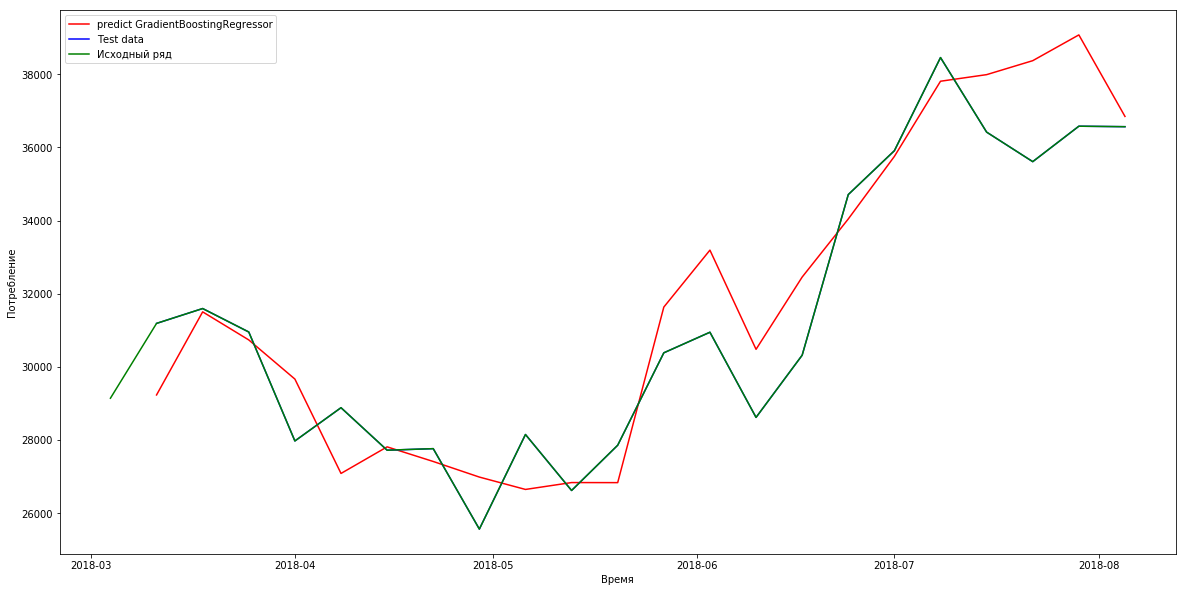

средняя ошибка в % отношении:   3.8720940665666364 %


In [36]:
model_gb = GradientBoostingRegressor(max_depth=7, random_state=0, n_estimators=100)
model_gb.fit( X_train, y_train ) 
y_pred = model_gb.predict(X_test)
plt.figure( figsize=( 20, 10 ))
plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(test.index[h:],y_pred, label='predict GradientBoostingRegressor',color='r' )
plt.plot(test.index[h:],y_test, label='Test data',color='b')
plt.plot(data_w.loc[spl_data:].index, data_w.loc[spl_data:]['PJME_MW'], label='Исходный ряд',color='g')
plt.legend()
plt.show()
er_g = mean_absolute_percentage_error(y_true=y_test, y_pred = y_pred)
print('средняя ошибка в % отношении:  ', er_g, '%')

In [37]:
h4 = 4
for i in range(5):
    er_g = mean_absolute_percentage_error(y_true=y_test[i*h4:i*h4+h4], y_pred = y_pred[i*h4:i*h4+h4])
    print(f'средняя ошибка на интервале {i*h4}:{i*h4+h4} \t {round(er_g,2)} %')

средняя ошибка на интервале 0:4 	 3.33 %
средняя ошибка на интервале 4:8 	 3.35 %
средняя ошибка на интервале 8:12 	 3.49 %
средняя ошибка на интервале 12:16 	 5.69 %
средняя ошибка на интервале 16:20 	 3.55 %


In [38]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_pred) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_pred) 
er_r2 = r2_score(y_true=y_test, y_pred=y_pred)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   2157392.6032438152 
ошибка mae  :   1202.1973493946844 
оценка R2 :   0.8483573916582156


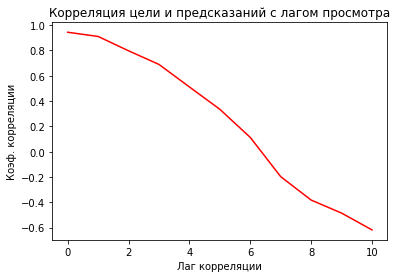

In [39]:
lag=10
p_cor=[np.corrcoef( y_test, y_pred)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_pred[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor),color='r' )  
plt.xlabel('Лаг корреляции')
plt.ylabel('Коэф. корреляции')
plt.title('Корреляция цели и предсказаний с лагом просмотра')
plt.show()

In [40]:
y_pred4,y_pred[3:], y_test[3:]

(array([27403.54577016, 28170.77108918, 27169.56083784, 29676.11063055,
        27664.26708548, 27227.67775752, 27528.59037625, 27927.63060591,
        28059.04575064, 32964.92866858, 31937.62303644, 32423.01139277,
        36705.88249975, 37789.93406168, 37272.11075335, 37635.06864569,
        37608.00760352, 37784.32760218, 36027.60171309]),
 array([29664.27033593, 27082.31964884, 27809.70703145, 27409.5925564 ,
        26983.11095199, 26644.76387296, 26832.96215245, 26830.88561197,
        31633.54834218, 33191.59380279, 30477.82622842, 32454.98417286,
        34044.31897546, 35756.2142137 , 37812.11875964, 37992.58887647,
        38374.70890223, 39079.52456804, 36849.38885406]),
 array([27970.83928571, 28880.98809524, 27718.25      , 27760.45833333,
        25559.9702381 , 28147.99404762, 26616.10714286, 27854.14285714,
        30382.39285714, 30945.60119048, 28615.1547619 , 30316.94047619,
        34711.64880952, 35911.83928571, 38459.98214286, 36420.03571429,
        35612.095238

In [41]:
len(y_pred4), len(y_pred), len(y_test)

(19, 22, 22)

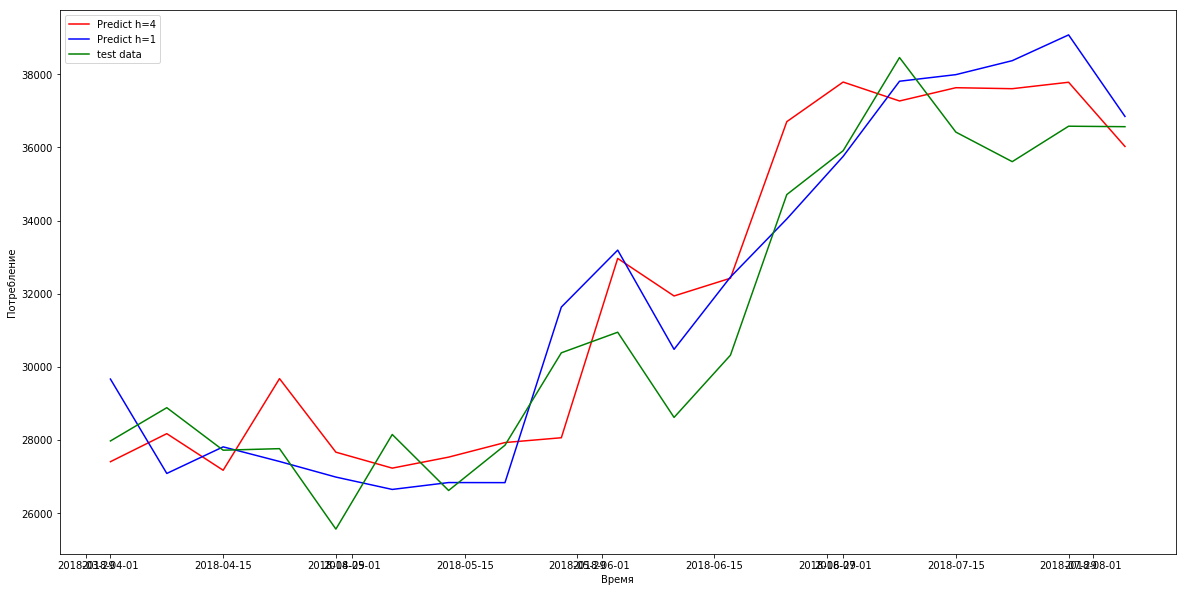

In [42]:
plt.figure( figsize=( 20, 10 ))

plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(test.index[4:],y_pred4, label='Predict h=4',color='r' )
plt.plot(test.index[4:],y_pred[3:], label='Predict h=1',color='b' )
plt.plot(test.index[4:],y_test[3:], label='test data',color='g')

plt.legend()

### Задача № 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.



_Построим рекурсивную модель на основе модели для h=1_

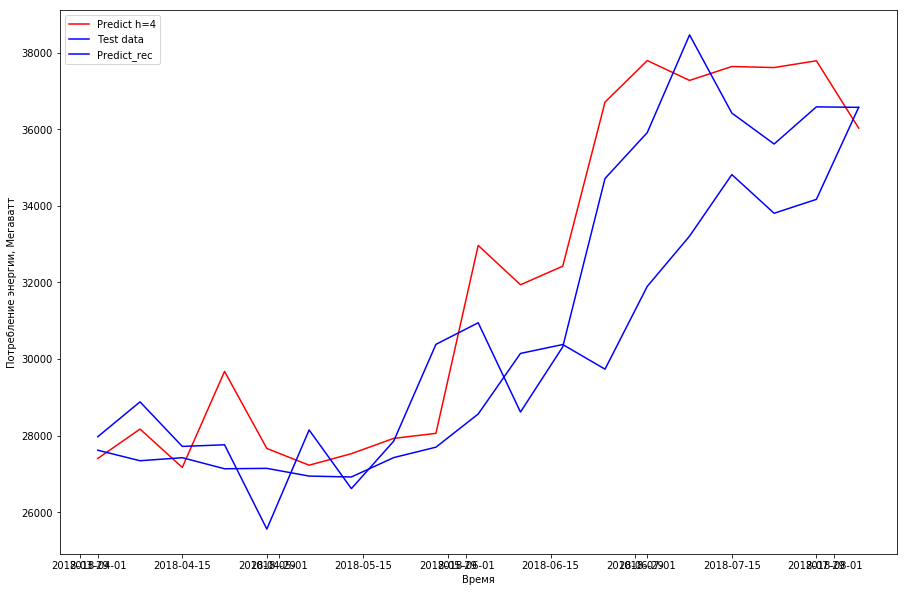

In [43]:
X_r = X_test.copy()
y_r = y_test.copy()
N = 21#22 точки у y_test
for i in range(N):
    y_r[i] = model_gb.predict(X_r.iloc[i:])[0]
                               
    # заполняем вектор для прогноза следующей точки
    X_r.iloc[i+1,0] = y_r[i]
    X_r.iloc[i+1,5] = X_r.iloc[i,0]
    if i > 0:
        X_r.iloc[i+1,6] = X_r.iloc[i-1,0]
    if i > 1:
        X_r.iloc[i+1,7] = X_r.iloc[i-2,0]
    if i > 2:
        X_r.iloc[i+1,8] = X_r.iloc[i-3,0]
    X_r.iloc[i+1,10] = X_r.iloc[i+1,0] - X_r.iloc[i+1,5]
    
    
    #строим 'exp_0_05', 
    X_r.iloc[i+1,9] = X_r.iloc[i,9]*(1-0.05)+ 0.05 * X_r.iloc[i+1,0] 
         
plt.figure( figsize=( 15, 10 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, Мегаватт')

plt.plot(test.index[4:],y_pred4, label='Predict h=4',color='r' )
plt.plot(test.index[4:],y_test[3:], label='Test data',color='b')
plt.plot(test.index[4:],y_r[3:], label='Predict_rec',color='b')
plt.legend()
plt.show()    

### Задача №  5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... ,от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p=6))

In [44]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_r) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_r) 
er_r2 = r2_score(y_true=y_test, y_pred=y_r)
print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   6012813.602395445 
ошибка mae  :   1918.700141452913 
оценка R2 :   0.5773607748681242


В целом рекурсивная модель показывает общий результат предсказания хуже чем в предыдущих моделях.

In [45]:
h4 = 4
print(f'\t\t\t\t\t pred_rec\t h=4')
for i in range(4):
    er_g = mean_absolute_percentage_error(y_true=y_test[i*h4:i*h4+h4], y_pred = y_r[i*h4:i*h4+h4])
    er_g4 = mean_absolute_percentage_error(y_true=y_test[i*h4+3:i*h4+h4], y_pred = y_pred4[i*h4:i*h4+h4])
    print(f'средняя ошибка на интервале {i*h4}:{i*h4+h4} \t {round(er_g,2)} %\t\t {round(er_g4,2)} %')

					 pred_rec	 h=4
средняя ошибка на интервале 0:4 	 7.63 %		 2.93 %
средняя ошибка на интервале 4:8 	 3.71 %		 7.93 %
средняя ошибка на интервале 8:12 	 3.95 %		 7.0 %
средняя ошибка на интервале 12:16 	 6.9 %		 7.6 %


### Задача №  6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

##### На первом интервале модель с h = 4 показывает более точную модель чем в рекурсивной модели, но начиная со второй рекурсивная модель показывает более точную модель хотя на всем участке предсказания в целом точность меньше. Можно отметить что рекурсивная модель ведет себя более сглаженно.